# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [2]:
df = np.loadtxt('dataset.txt')
arms=df[:,0].astype(int).ravel()
rewards=df[:,1].astype(int).ravel()
contexts = df[:,2:102].astype(int)

In [3]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [4]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Q = np.full(self.narms,Q0)
        self.arm_count = np.zeros(narms)
        self.arm_rewards = np.zeros(narms)
        
    def play(self, tround, context=None):
        max_arms=np.argwhere(self.Q == np.amax(self.Q)).flatten().tolist()
        if np.random.random() > self.epsilon:
            selected_arm=np.random.choice(np.argwhere(self.Q == np.amax(self.Q)).flatten().tolist())
        else:
            selected_arm=np.random.randint(self.narms)
        
        return selected_arm
        
    def update(self, arm, reward, context=None):
        self.arm_count[arm] += 1.0
        self.arm_rewards[arm] += reward
        if self.arm_count[arm] != 0:
            self.Q[arm]=float(self.arm_rewards[arm]) / float(self.arm_count[arm])
 

In [5]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms=narms
        self.rho=rho
        self.Q = np.full(self.narms,Q0)
        self.mu=np.zeros(narms)
        self.arm_count=np.zeros(narms)
        self.arm_rewards=np.zeros(narms)
    
    def play(self, tround, context=None):
        for arm in range(self.narms):
            if self.arm_count[arm]!=0:
                self.Q[arm]= self.mu[arm] + np.sqrt((self.rho * np.log(tround)) / float(self.arm_count[arm]))
        
        max_arms=np.argwhere(self.Q == np.amax(self.Q)).flatten().tolist()
        selected_arm=np.random.choice(max_arms)
        return selected_arm
  
        
    def update(self, arm, reward, context=None):
        self.arm_count[arm]+=1.0
        self.arm_rewards[arm]+=reward
        if self.arm_count[arm] != 0:
            self.mu[arm]=float(self.arm_rewards[arm]) / float(self.arm_count[arm])

## 2. Off-Policy Evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    tround = 0
    R = list()
    
    # if no rounds then we will record all per round rewards
    if nrounds is None:
        nrounds=len(df)
        
    for log_event in range(len(df)):
        
        if tround > nrounds:
            break
        
        arm=mab.play(tround + 1,contexts[log_event]) 
        predicted_arm=arm + 1 # adding 1 to compensate python array index
        if predicted_arm == arms[log_event]:
            mab.update(arm, rewards[log_event], contexts[log_event])
            R.append(rewards[log_event])
            tround += 1
    
    return R
     

In [7]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.18976279650436953


In [30]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.15730337078651685


## 3. Contextual Bandits

In [9]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms=narms
        self.alpha=alpha
        self.ndims=ndims
        self.A=[np.identity(ndims) for arm in range(narms)]
        self.b=[np.zeros((ndims,1)) for arm in range(narms)]
        
             
    def play(self, tround, context):
        p=np.zeros(self.narms)
        for arm in range(self.narms):
            x_arm = context[arm*self.narms:arm*self.narms+self.ndims].reshape(-1,1)
            theta_hat_arm = np.dot(inv(self.A[arm]), self.b[arm])
            p[arm] = np.asscalar(np.dot(theta_hat_arm.T, x_arm) + self.alpha * np.sqrt(np.dot(np.dot(x_arm.T, inv(self.A[arm])), x_arm)))
        
        max_arms=np.argwhere(p == np.amax(p)).flatten().tolist()
        selected_arm=np.random.choice(max_arms)
        return selected_arm
    
    def update(self, arm, reward, context):
        x_arm = context[arm*self.narms:arm * self.narms + self.ndims].reshape(-1,1)
        self.A[arm] = self.A[arm] + np.dot(x_arm,x_arm.T)
        self.b[arm] = self.b[arm] + reward * x_arm

In [10]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts,800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.5305867665418227


## 4. Evaluation
### 4.A.

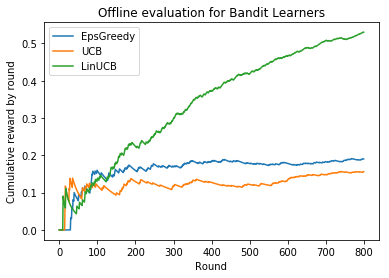

In [31]:
T=800
results_EpsGreedy_T=np.zeros(T)
results_UCB_T=np.zeros(T)
results_LinUCB_T=np.zeros(T)
for t in range(T):
    results_EpsGreedy_T[t]=float(np.sum(results_EpsGreedy[0:t+1]))/float(t+1)
    results_UCB_T[t]=float(np.sum(results_UCB[0:t+1]))/float(t+1)
    results_LinUCB_T[t]=float(np.sum(results_LinUCB[0:t+1]))/float(t+1)
    

plt.plot(results_EpsGreedy_T,label='EpsGreedy')
plt.plot(results_UCB_T,label='UCB')
plt.plot(results_LinUCB_T,label='LinUCB')
plt.legend()
plt.title("Offline evaluation for Bandit Learners")
plt.xlabel("Round")
plt.ylabel("Cumulative reward by round")
plt.show()

### 4.B.

Best alpha: 0.001  with an average reward of: 0.717852684144819


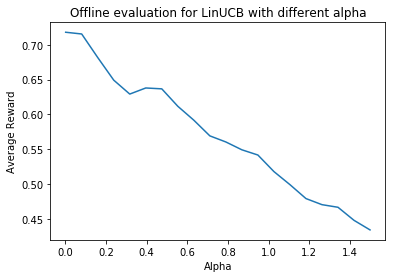

In [35]:
n=20
start=0.001
top=1.5
alpha_search=np.linspace(start, top, n)
lin_ucb_eval=list()
linucb_eval={}
for alpha in alpha_search:
    mab = LinUCB(10, 10, alpha)
    lin_ucb_eval.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))
    
alpha_eval = dict(zip(alpha_search,lin_ucb_eval))   
max_alpha=max(alpha_eval, key=alpha_eval.get)
print ("Best alpha:",max_alpha, " with an average reward of:",alpha_eval[max_alpha])
plt.plot(alpha_search,lin_ucb_eval)
plt.title("Offline evaluation for LinUCB with different alpha")
plt.xlabel("Alpha")
plt.ylabel("Average Reward")
plt.show()

## 5. KernelUCB

In [13]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        
    
    def play(self, tround, context):
        
    
    def update(self, arm, reward, context):
        
    